## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, roc_auc_score

from pysim import SimClassifier

## pySIM - A python package for Sparse SIM 

**To install**:
    
```sheel
    pip install git+https://github.com/Zebinyang/pysim.git
```

Note pysim will call the R package fps (https://github.com/vqv/fps) using rpy2 interface. 

```python
from pysim import SimClassifier
clf = SimClassifier(method="first_order", reg_lambda=0.1, reg_gamma=10, knot_num=20, degree=2, random_state=0)
## clf.fit(x, y)
```

**Usage**

**Hyperparameters**

- method: the base method for estimating the projection coefficients in sparse SIM. default="first_order"

        "first_order": First-order Stein's Identity via sparse PCA solver

        "second_order": Second-order Stein's Identity via sparse PCA solver

        "first_order_thres": First-order Stein's Identity via hard thresholding (A simplified verison)        
    
- reg_lambda: The regularization strength of sparsity of beta. default=0.1, from 0 to 1 

- reg_gamma: The regularization strength of the spline algorithm. default=10, from 0 to $+\infty$

- degree: The order of the spline basis. default=2

- knot_num: The number of knots spanned uniformly over the domain. default=20

- random_state: the random seed. default=0

# Case 1: Logit Function

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 1 / (1 + np.exp(-(np.dot(x, beta)))) + 0.1 * np.random.randn(n_samples)
y = y - np.mean(y)
y[y <= 0] = 0
y[y > 0] = 1

The best hyperparameter combination can be selected via cross-validation

In [3]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5],
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  90 | elapsed:   13.3s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  55 out of  90 | elapsed:   15.1s remaining:    9.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   16.4s finished


CPU times: user 33.8 s, sys: 4.79 s, total: 38.5 s
Wall time: 19.3 s


In [4]:
grid.best_params_

{'method': 'first_order', 'reg_gamma': 0.1, 'reg_lambda': 0.2}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [5]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='first_order', random_state=0,
              reg_gamma=0.1, reg_lambda=0.2)

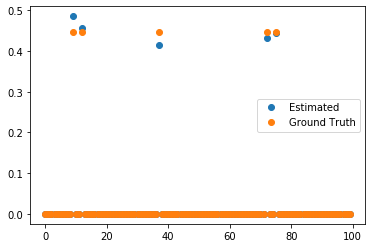

In [6]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

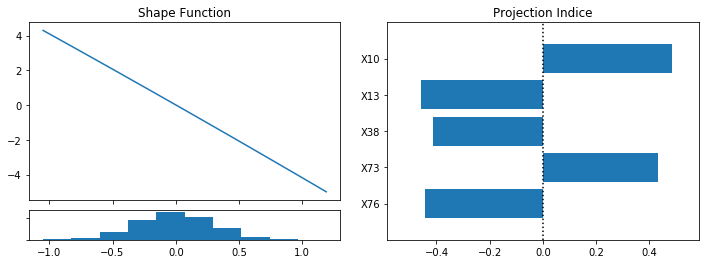

In [7]:
grid.best_estimator_.visualize()

In [8]:
roc_auc_score(y, grid.predict_proba(x))

0.7765179279005547

## Case 2: Quadratic Ridge Function

In [9]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [10]:
%%time 

param_grid = {"method": ["first_order", "second_order"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5],
              "reg_gamma": np.logspace(-1, 1, 3)}
grid = GridSearchCV(SimClassifier(degree=2, knot_num=20, random_state=0), 
                    cv=KFold(3, shuffle=True, random_state=0), 
                    scoring={"auc": make_scorer(roc_auc_score)},
                    param_grid=param_grid, n_jobs=-1, verbose=2, refit="auc", error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  90 | elapsed:    0.9s remaining:    8.3s
[Parallel(n_jobs=-1)]: Done  55 out of  90 | elapsed:    2.0s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    2.8s finished


CPU times: user 40.8 s, sys: 4.74 s, total: 45.5 s
Wall time: 6.29 s


In [11]:
grid.best_params_

{'method': 'second_order', 'reg_gamma': 0.1, 'reg_lambda': 0.1}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [12]:
clf = grid.best_estimator_
clf

SimClassifier(degree=2, knot_num=20, method='second_order', random_state=0,
              reg_gamma=0.1, reg_lambda=0.1)

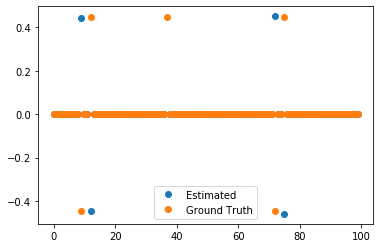

In [13]:
plt.plot(clf.beta_, "o")
plt.plot(beta, "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

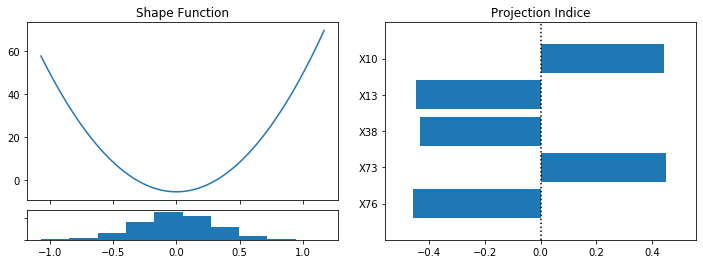

In [14]:
grid.best_estimator_.visualize()

## Case 3: Improve a rough estimator via inner update

In [15]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = 5 * np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)
ymu = np.mean(y)
y[y > ymu] = 1
y[y <= ymu] = 0

In [16]:
%%time 

clf = SimClassifier(degree=2, knot_num=20, reg_lambda=0.2, reg_gamma=1, random_state=0)
clf.fit(x, y)

CPU times: user 31.8 s, sys: 3.68 s, total: 35.5 s
Wall time: 2.69 s


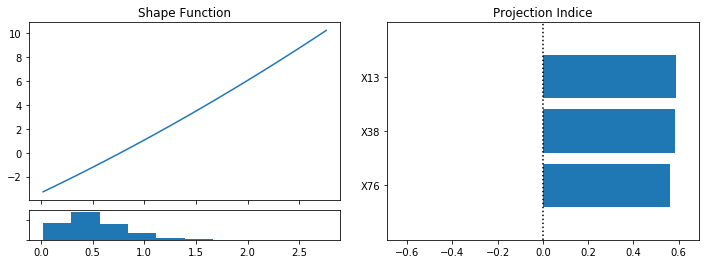

In [17]:
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poor.

In [18]:
clf.fit_inner_update(x, y, verbose=True)

Inner iter: 1 epoch: 1 with validation loss: 0.42527
Inner iter: 1 epoch: 2 with validation loss: 0.42286
Inner iter: 1 epoch: 3 with validation loss: 0.42255
Inner iter: 1 epoch: 4 with validation loss: 0.42212
Inner iter: 1 epoch: 5 with validation loss: 0.42213
Inner iter: 1 epoch: 6 with validation loss: 0.42025
Inner iter: 1 epoch: 7 with validation loss: 0.41862
Inner iter: 1 epoch: 8 with validation loss: 0.41485
Inner iter: 1 epoch: 9 with validation loss: 0.41075
Inner iter: 1 epoch: 10 with validation loss: 0.40495
Inner iter: 1 epoch: 11 with validation loss: 0.39921
Inner iter: 1 epoch: 12 with validation loss: 0.39074
Inner iter: 1 epoch: 13 with validation loss: 0.38328
Inner iter: 1 epoch: 14 with validation loss: 0.37515
Inner iter: 1 epoch: 15 with validation loss: 0.36756
Inner iter: 1 epoch: 16 with validation loss: 0.36
Inner iter: 1 epoch: 17 with validation loss: 0.35373
Inner iter: 1 epoch: 18 with validation loss: 0.34751
Inner iter: 1 epoch: 19 with validation 

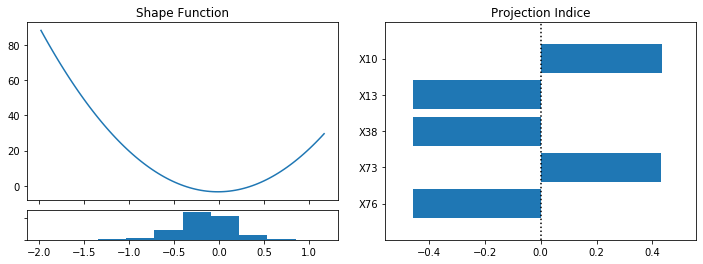

In [19]:
clf.visualize()